In [ ]:
from glob import glob
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
from torchvision import datasets, models, transforms
from PIL import Image
from torch.autograd import Variable
from torch import nn, optim, cuda
import cv2
from skimage.transform import rescale, resize
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
from shutil import copyfile

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

from google.colab import drive

drive.mount('/content/drive')

cuda
Mounted at /content/drive


# **Get Model**

In [ ]:
model_version = "alex_8"
params_file = model_version + '_params.pth' #model version to use

#get model
model_dir = '/content/drive/My Drive/Lake detection/models/'

params = torch.load(model_dir + params_file)
model_name = params['name']
model = torch.load(model_dir + model_name)

for param in model.parameters():
    param.requires_grad = False

model.eval();

preprocess = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                     ])

In [ ]:
def get_prediction(probs, th):

    if np.asarray(probs.cpu()[0])[4] > th:
        predicted = 4
    else:
        pred = np.asarray(probs.cpu()[0])
        pred[4] = 0
        predicted = np.argmax(pred)

    return predicted

# **Classify tiles**

In [ ]:
th = 0.7


In [ ]:
#ice test
clas = 6
types = {0:'smooth ice', 1:'textured ice', 2:'remnant', 3:'water', 4:'subsurface', 5:'mountains', 6:'land'}
print(types[clas])
ice_imgs = glob('/content/drive/My Drive/Lake detection/greenland/test/' + str(clas) + '/*.jpg')
ice = 0
ice2 = 0
sub = 0
rem = 0
wat = 0 
mtn = 0
land = 0

for img_path in ice_imgs:
    img = Image.open(img_path)
    img = preprocess(img)
    img2 = np.expand_dims(img, 0) #Convert 2D image to 1D vector
    img2 = torch.from_numpy(img2)

    #classify image
    inputs = Variable(img2).to(device)
    outputs = model(inputs) #labels
    probabilites = torch.softmax(outputs.data, 1) #get probability for each class
    pred = get_prediction(probabilites, th)
    if pred == 0:
      ice = ice + 1
    elif pred == 1:
      ice2 = ice2 + 1
    elif pred == 2:
      rem = rem + 1
    elif pred == 3:
      wat = wat + 1
    elif pred == 4:
      sub = sub + 1
    elif pred == 5:
      mtn = mtn + 1
    elif pred == 6:
      land = land + 1

print(f'classified as smooth ice: {ice}')
print(f'classified as textured ice: {ice2}')
print(f'classified as subsurface: {sub}')
print(f'classified as remnant: {rem}')
print(f'classified as water: {wat}')
print(f'classified as mtn: {mtn}')
print(f'classified as land: {land}')

land
classified as smooth ice: 1
classified as textured ice: 1
classified as subsurface: 0
classified as remnant: 1
classified as water: 0
classified as mtn: 0
classified as land: 31


In [ ]:
precision = 184/(184+14)
recall = 184/(184+25)
F1 = 2*precision*recall/(precision + recall)
print(precision, recall, F1)

0.9292929292929293 0.8803827751196173 0.9041769041769042


In [ ]:
y_true = list()
y_pred = list()
for i in range(172):
  y_true.append(0)
  y_pred.append(0)
for i in range(6):
  y_true.append(1)
  y_pred.append(0)
y_true.append(2)
y_pred.append(0)
y_true.append(6)
y_pred.append(0)
for i in range(16):
  y_true.append(0)
  y_pred.append(1)
for i in range(110):
  y_true.append(1)
  y_pred.append(1)
for i in range(17):
  y_true.append(2)
  y_pred.append(1)
for i in range(16):
  y_true.append(4)
  y_pred.append(1)
y_true.append(5)
y_pred.append(1)
y_true.append(6)
y_pred.append(1)
y_true.append(0)
y_pred.append(2)
for i in range(12):
  y_true.append(1)
  y_pred.append(2)
for i in range(195):
  y_true.append(2)
  y_pred.append(2)
for i in range(7):
  y_true.append(4)
  y_pred.append(2)
for i in range(14):
  y_true.append(3)
  y_pred.append(3)
y_true.append(6)
y_pred.append(2)
for i in range(2):
  y_true.append(0)
  y_pred.append(4)
for i in range(7):
  y_true.append(1)
  y_pred.append(4)
for i in range(5):
  y_true.append(2)
  y_pred.append(4)
for i in range(184):
  y_true.append(4)
  y_pred.append(4)
for i in range(3):
  y_true.append(1)
  y_pred.append(5)
for i in range(2):
  y_true.append(4)
  y_pred.append(5)
y_true.append(2)
y_pred.append(5)
for i in range(76):
  y_true.append(5)
  y_pred.append(5)
for i in range(2):
  y_true.append(2)
  y_pred.append(6)
for i in range(4):
  y_true.append(5)
  y_pred.append(6)
for i in range(31):
  y_true.append(6)
  y_pred.append(6)


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

[Text(0, 0.5, 'smooth \nice'),
 Text(0, 1.5, 'textured \nice'),
 Text(0, 2.5, 'remnant \nlake'),
 Text(0, 3.5, 'ocean'),
 Text(0, 4.5, 'buried \nlake'),
 Text(0, 5.5, 'land'),
 Text(0, 6.5, 'mountain')]

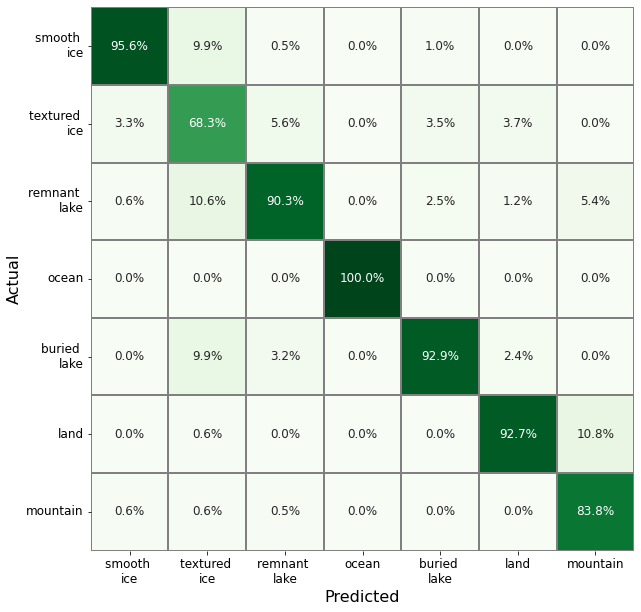

In [ ]:

labels = ['smooth \nice', 'textured \nice', 'remnant \nlake', 'ocean', 'buried \nlake', 'land', 'mountain']
c = confusion_matrix(y_true, y_pred, normalize = 'pred')

fig, ax = plt.subplots(1,1,figsize = (12,10))
sns.heatmap(c, annot=True, fmt = ".1%", cmap = 'Greens',cbar = False,square = True,linecolor = 'gray', linewidths = 1, annot_kws={'fontsize':'large'})
ax.set_xlabel('Predicted', fontsize = 16)
ax.set_ylabel('Actual', fontsize = 16)
ax.set_xticklabels(labels, fontsize = 12)
ax.set_yticklabels(labels, fontsize = 12, rotation = 00, va="center")